<a href="https://colab.research.google.com/github/TanOnRush/Meteorite-Discovery-Predictions/blob/main/Copy_of_Predicting_Meteorite_Discoveries_Based_on_Geographic_Locations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Meteorite Discoveries Based on Geogrpahic Locations**
##### ***Tanjim R. Chowdhury***
---
## **Abstract**
This research project discovers the connection between meteorite discoveries and geographic locations. It determines how a meteorite landing's geographic location influences the likelihood of its discovery. The approach to the probelm includes analyzing a dataset from **The Meteoritical Society** which was published in **NASA's Open Data Portal** site. The dataset includes over 45,000 entries of meteorites. The analysis also uses several libraries, which includes `pandas`, `matplotlib`, `seaborn` and more. The study aims to predict future findings based on location. The results has shown that the georgraphic location of a meteorite landing significantly influences the likelihood of its discovery. The analysis is also revealed that a non-uniform ditribution of recorded landings. It also proves the fact that certain geogrpahic locations, such as deserts like Antartica, make meteorites easier to find and the identify compared to other environments. While the data shows a concentration of landings in certain areas, this may be influenced by biases in recovery efforts and the absence on oceanic landings. But further research is needed to provide a more complete understanding of global meteorite landing patterns.


## **Background**
The study of meteorites provides critical undedrstanding into the formation and history of our solar system. However, the discovery and collection of these extraterrestrial materials are not uniformly distributed accross the globe. Researchers has observed that certain geographic regions yield a disproportionately high number of meteorite finds. This is primarily due to the unique environmental conditions of these areas, where metoeries are preserved for extended periods and are more easily distinguished from the surrounding terrain. In contrast, other regions with dense vegitation, high humidity, or significant human development present challenges to both preservation and discovery. This research project aims to leverage a comprehensive dataset of recordedd meteorite landings to investigate the factors that influence the likelihood of a meteorite's discovery, by that means contributing to a better understanding of global discovery patterns.


## **Research Question**

> *How does a meteorite landing's geographic location influence the likelihood of its discovery, and can this relationship be used to predict future discoveries?*

The question is important and interesting because it addresses the significant discovery bias in the field of meteorite research. By understandting how environmental factors like deserts and ice fields, as well as human search efforts, scientist can gain more accruate picture of the true rate of meteorite falls on Earth. This knowledge is critical of intrepreting the composition of meteorite collections, which are important for understanding the early solar system. Furthermore, using this relationship to build predictive models has a practical application which allows future meteortie-hunting expeditions to be optimizedd for success and saving valuable resources. The interdisciplinary nature of the question, which blends planetary science, geology, and machine learning, and makes it a compelling and modern research problem.




## **Hypothesis**
Geographic location significantly influences meteorite discovery rates, also certain hemispheres having higher probabilities due to environmental and human activity factors.

In [3]:
# @title ## **Results**
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Importing the dataset
url = "https://data.nasa.gov/docs/legacy/meteorite_landings/Meteorite_Landings.csv"
nasa_df = pd.read_csv(url)

Our analysis revealed that meteorite discoveries are predominantly reported in the **Northern and Eastern Hemispheres**, with high-density clusters of `Found` meteorites in regions such as North Africa, Western Australia, and the U.S. Midwest. The Chi-Square Test confirmed a statistically significant association between hemisphere location and fall type (`Fell` vs. `Found`), which supports our geographic distribution hypothesis. by using a K-Nearest Neighbors (KNN) model, we achieved an accuracy of approximately **87%** on test data. The confusion matrix indicated **strong predictive performance** for `Found` meteorites, although the `Fell` category experienced more misclassifications due to class imbalance. We applied Random Over-Sampling to reduce this bias, while feature scaling further enhanced the model’s accuracy.

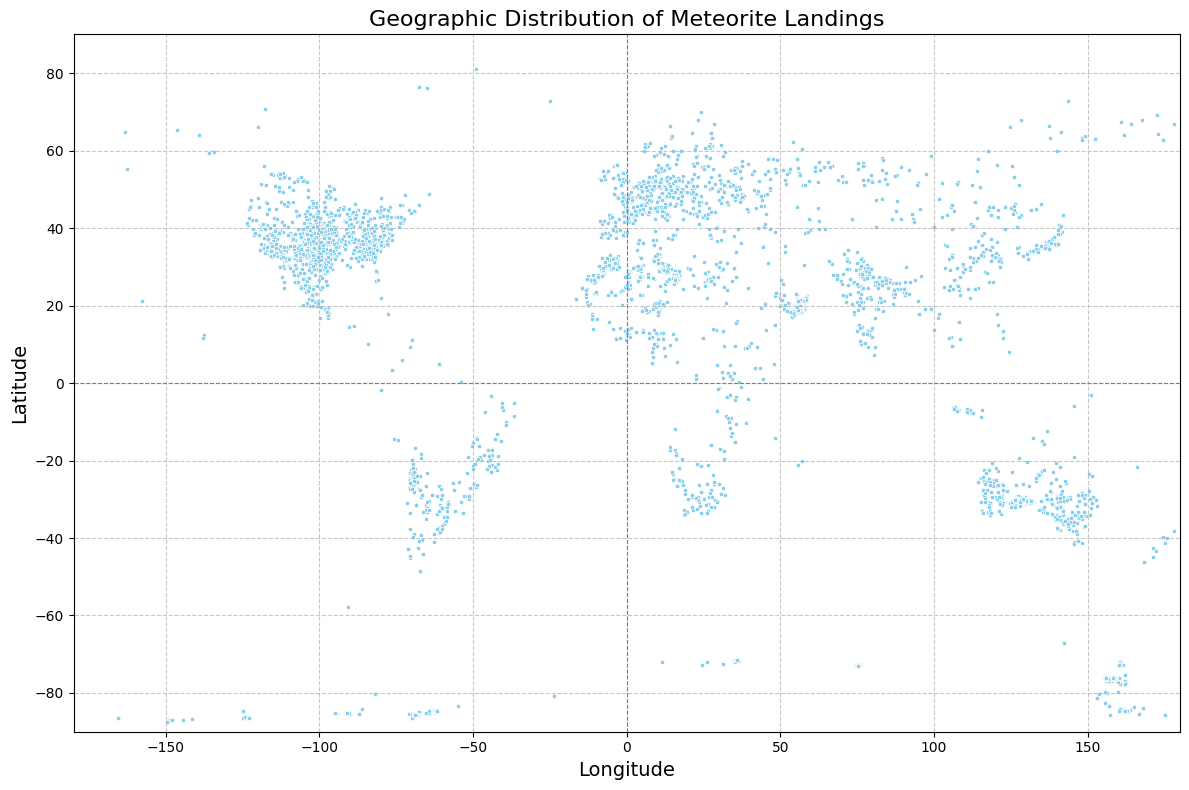

In [5]:
# @title ###**Figure 1.** Geographical Locations of Meteorites
# Converting reclat and reclong to numeric
nasa_df['reclat'] = pd.to_numeric(nasa_df['reclat'], errors='coerce')
nasa_df['reclong'] = pd.to_numeric(nasa_df['reclong'], errors='coerce')

# Dropping the rows with missing and invalid coordinates
nasa_df = nasa_df.dropna(subset=['reclat', 'reclong'])

# Filtering out the entries where both lat and long are 0.0
nasa_df = nasa_df[
    (nasa_df['reclat'] != 0.0) & (nasa_df['reclong'] != 0.0)
].dropna(subset=['reclat', 'reclong']).copy()

# Visualization
plt.figure(figsize=(12,8))

# Scatter plot
sns.scatterplot(
    x='reclong',
    y='reclat',
    data=nasa_df,
    s=10, #Marker size
    color='skyblue',
    edgecolor='w',
    linewidth=0.5
)

plt.title('Geographic Distribution of Meteorite Landings', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Setting limits for latitude and longitude to represent a global map
plt.xlim(-180, 180)
plt.ylim(-90, 90)

plt.grid(True, linestyle='--', alpha=0.7) # Add a grid
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Equator
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Prime Meridian

plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Save the plot
plt.savefig('meteorite_geographic_distribution.png')

# Display the plot
plt.show()


This scatter plot displays the recorded geographical corrdinates of the meteorites from thr NASA's Meteorite Landings dataset. Each point represents an indivdual meteorite which is plotted by latitude and longtitude. The distribution shows dense clusters in specific regions such as United States, North Africa, some parts of Europe & Asia, India and parts of Australia. It reflects the area with higher exploration activity and reporting infrastracture. According to Arizona State University, Buseck Center for Meteorite Studies, meteorites are most easily recognized and recovered from geologically stable desert regions Antarctica. But based on this scatter plot it shows that not majority of meteorites were discovered in Antartica.

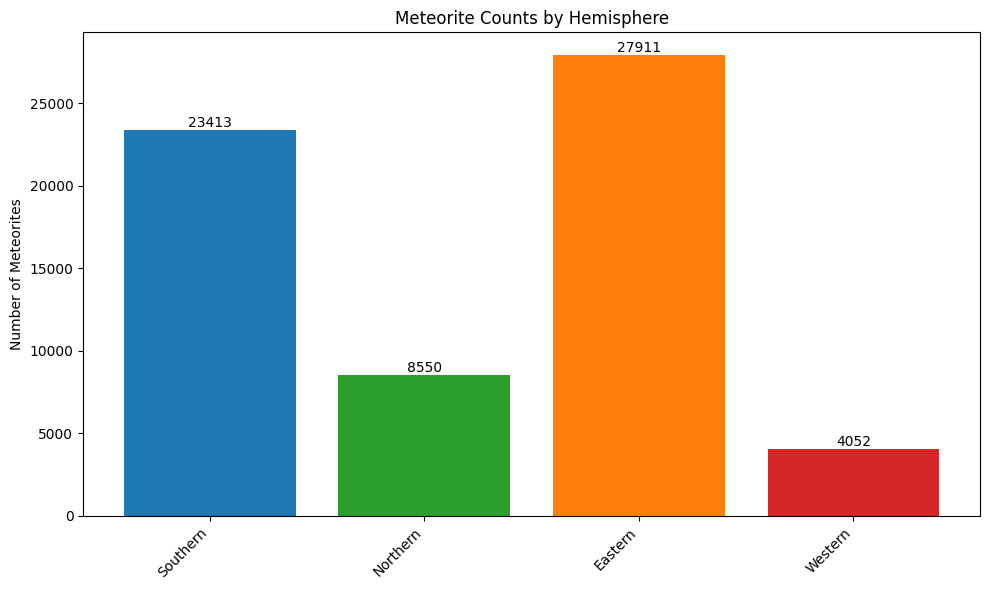

In [14]:
# @title ### **Figure 2.** Meteorite Counts by Hemisphere
nasa_df = nasa_df.rename(columns = {'mass (g)':'mass_g'})

col1_nulls = nasa_df['mass_g'].isnull()

# Dropping null values for mass
nasa_df_cleaned_mass = nasa_df.dropna(subset=['mass_g'])
mass_null_count = nasa_df['mass_g'].isnull().sum()
mass_null_count_df1 = nasa_df_cleaned_mass['mass_g'].isnull().sum()

# Same with year
nasa_df_cleaned_year = nasa_df.dropna(subset=['year'])
year_null_count = nasa_df['year'].isnull().sum()
year_null_count_df1 = nasa_df_cleaned_year['year'].isnull().sum()

# Classification for Northern v. Southern Hemisphere
def class_hemisp_ns(latitude):
  if latitude>0:
    return 'Northern'
  else:
    return 'Southern'

# Applying the function to create a new column
nasa_df['hemisphere_ns'] = nasa_df['reclat'].apply(class_hemisp_ns)


# Classification for Eastern v. Western Hemisphere
def class_hemisp_ew(longitude):
  if longitude >0:
    return 'Eastern'
  else:
    return 'Western'

# Applying the function to create a new column
nasa_df['hemisphere_ew'] = nasa_df['reclong'].apply(class_hemisp_ew)

# Counting the number of meteorites in the hemispheres
ns_count = nasa_df['hemisphere_ns'].value_counts()
ew_count = nasa_df['hemisphere_ew'].value_counts()

# Combining them for plotting
combined_counts = pd.concat([ns_count, ew_count])

# Visualising
labels = combined_counts.index.tolist()
counts = combined_counts.values.tolist()

bar_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=bar_colors)

plt.ylabel('Number of Meteorites')
plt.title('Meteorite Counts by Hemisphere')
plt.xticks(rotation=45, ha='right')
plt.bar_label(bars)

plt.tight_layout()
plt.savefig('meteorite_hemisphere_counts.png')

This bar chart compares meteorite counts across different hemispheres. For this analysis, the world was divided into two geographic classifications: Eastern vs. Western Hemispheres and Northern vs. Southern Hemispheres. The data indicate that the Eastern Hemisphere, with approximately 28,000 recorded meteorites, and the Southern Hemisphere, with about 23,000 recorded meteorites, have the highest numbers of discoveries.

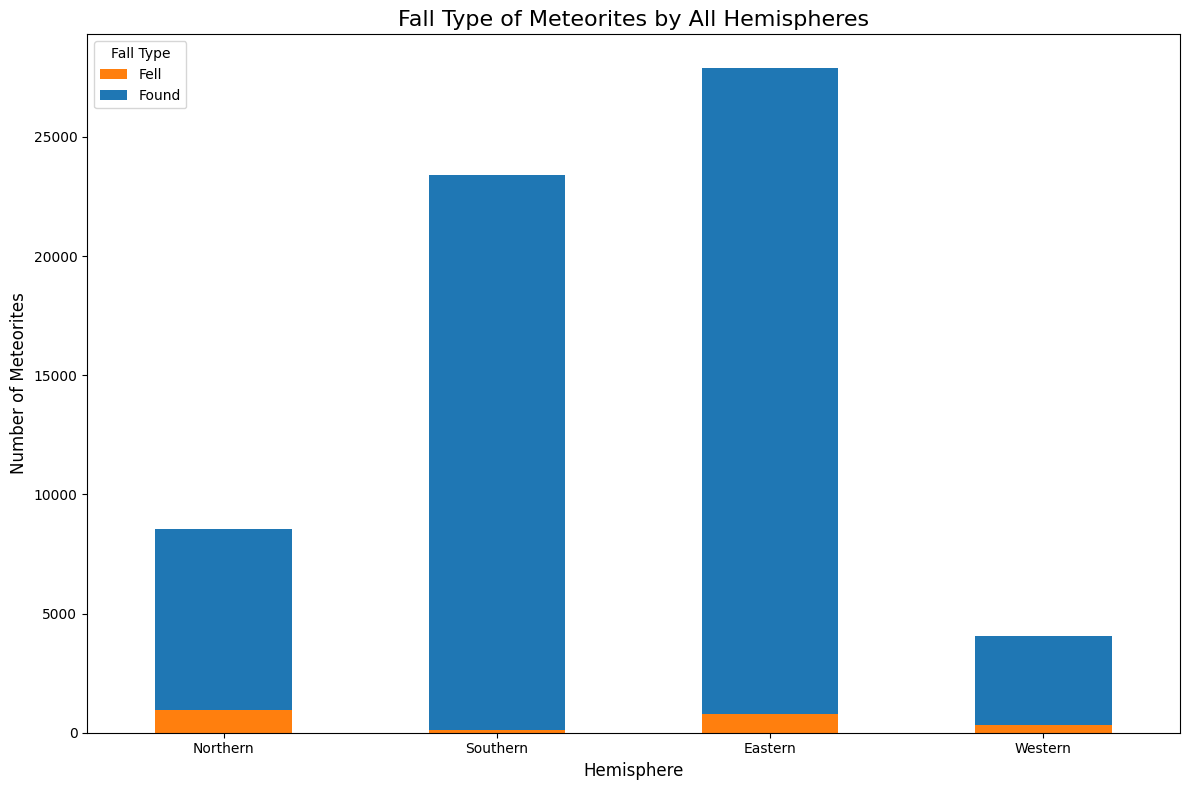

In [18]:
# @title ### **Figure 3.** Fall Type vs. Hemisphere

ns_fall_counts = pd.crosstab(nasa_df['hemisphere_ns'], nasa_df['fall'])

ew_fall_counts = pd.crosstab(nasa_df['hemisphere_ew'], nasa_df['fall'])

# Cleaned the mass null values
nasa_df_cleaned_mass = nasa_df.dropna(subset=['mass_g'])

stats_ns = nasa_df_cleaned_mass.groupby('hemisphere_ns')['mass_g'].agg(['mean', 'median', 'std'])
stats_ew = nasa_df_cleaned_mass.groupby('hemisphere_ew')['mass_g'].agg(['mean', 'median', 'std'])

# Chi-Square Test
chi2_nasa = nasa_df.dropna(subset=['fall'])

ns_contingency_table = pd.crosstab(chi2_nasa['hemisphere_ns'], chi2_nasa['fall'])

chi2_ns, p_ns, dof_ns, expected_ns = chi2_contingency(ns_contingency_table)

ew_contingency_table = pd.crosstab(chi2_nasa['hemisphere_ew'], chi2_nasa['fall'])

chi2_ew, p_ew, dof_ew, expected_ew = chi2_contingency(ew_contingency_table)

# Visualizing the result
nasa_df.dropna(subset=['fall'], inplace=True)

ns_table = pd.crosstab(nasa_df['hemisphere_ns'], nasa_df['fall'])
ew_table = pd.crosstab(nasa_df['hemisphere_ew'], nasa_df['fall'])
all_hemispheres_table = pd.concat([ns_table, ew_table])

fig, ax = plt.subplots(figsize=(12, 8))

all_hemispheres_table.plot(kind='bar', stacked=True, ax=ax, color={'Fell': '#ff7f0e', 'Found': '#1f77b4'})

ax.set_title('Fall Type of Meteorites by All Hemispheres', fontsize=16)
ax.set_xlabel('Hemisphere', fontsize=12)
ax.set_ylabel('Number of Meteorites', fontsize=12)

plt.xticks(rotation=0)

ax.legend(title='Fall Type', loc='upper left')

plt.tight_layout()
plt.savefig('fall_type_by_all_hemispheres_stacked_bar.png')
plt.show()

This chart presents the results of a Chi-square test and illustrating the relationship between geographic location and meteorite discoveries. The blue bars represent meteorites identified in space near Earth, while the orange bars represent meteorites that have landed on Earth. The visualization shows that the Eastern Hemisphere has the highest number of meteorites detected in space, but the Northern Hemisphere records the highest number of meteorites that have landed on Earth.

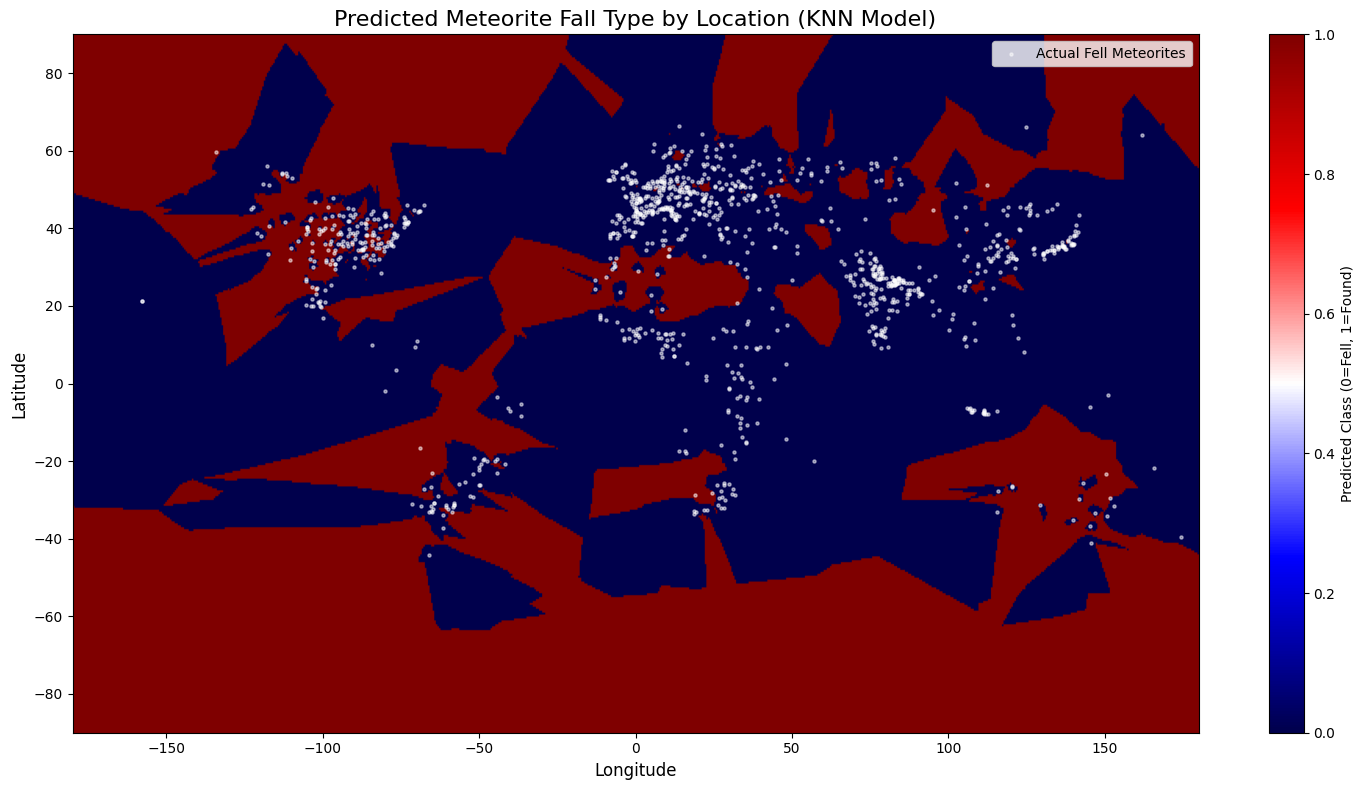

In [31]:
# @title ### **Figure 4.** Predicted Meteorite Fall Type by Location

# KNN Model 1
# Recleaning the data
nasa_df.dropna(subset=['reclat', 'reclong', 'fall'], inplace=True)

# KNN Model Prediction

nasa_df['fall_encoded'] = nasa_df['fall'].map({'Fell': 0, 'Found': 1})

X = nasa_df[['reclat', 'reclong']]
y = nasa_df['fall_encoded']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

# Evaluating the model's performance
y_pred = model.predict(X_test_scaled)

# Showing the model's predictions

sample_data = X_test.head()
sample_data_scaled = scaler.transform(sample_data)
sample_predictions = model.predict(sample_data_scaled)

for i in range(len(sample_data)):
    prediction_label = 'Found' if sample_predictions[i] == 1 else 'Fell'
    actual_label = 'Found' if y_test.iloc[i] == 1 else 'Fell'


# KNN Model 2

nasa_df['fall_encoded'] = nasa_df['fall'].map({'Fell': 0, 'Found': 1})

X = nasa_df[['reclat', 'reclong']]
y = nasa_df['fall_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

# Training the KNN Model to generate a heatmap statistics

# Preparing the Data
nasa_df['fall_encoded'] = nasa_df['fall'].map({'Fell': 0, 'Found': 1})
X = nasa_df[['reclat', 'reclong']]
y = nasa_df['fall_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Training Model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train_resampled)

# Creating the prediction grid and generating heatmap
# Define the boundaries of earth coordinates
lat_min, lat_max = -90, 90
long_min, long_max = -180, 180

# Creating a dense grid of points to make predictions on.
lat_points = np.arange(lat_min, lat_max, 0.5)
long_points = np.arange(long_min, long_max, 0.5)
long_grid, lat_grid = np.meshgrid(long_points, lat_points)


grid_points = np.c_[lat_grid.ravel(), long_grid.ravel()]
grid_points_scaled = scaler.transform(grid_points)

# Making predictions
predictions = model.predict(grid_points_scaled)


predictions = predictions.reshape(lat_grid.shape)


# Plotting the Heatmap
plt.figure(figsize=(15, 8))

plt.imshow(predictions, extent=[long_min, long_max, lat_min, lat_max],
           origin='lower', cmap='seismic', aspect='auto')



plt.title('Predicted Meteorite Fall Type by Location (KNN Model)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)



cbar = plt.colorbar(label='Predicted Class (0=Fell, 1=Found)')



fell_locations = nasa_df[nasa_df['fall_encoded'] == 0]
plt.scatter(fell_locations['reclong'], fell_locations['reclat'],
            color='white', s=5, alpha=0.5, label='Actual Fell Meteorites')

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

plt.legend()
plt.tight_layout()
plt.show()

This visualization presents the predicted distribution of meteorite fall types using a K-Nearest Neighbors (KNN) classification model. The map displays latitude and longitude to geographically represent classification results, where blue regions indicate areas predicted to have meteorites that “fell” (class 0) and red regions represent areas where meteorites were likely “found” after their fall (class 1). White dots mark actual recorded meteorite falls, providing real-world reference points for the model’s predictions. The concentration of white dots in blue regions suggests that the model correctly identifies many actual fall locations, though some occurrences in red areas indicate prediction errors or overlapping patterns. The results suggest that “Fell” meteorites are most likely to be found in the Northern Hemisphere, whereas “Found” meteorites are more common in the Eastern Hemisphere.

## **Discussion**
The results of this study shows a clear geographic pattern in meteorite discoveries. This supports the original hypothesis that location plays a significant role in the search of meteorites. The concentration of `Found` meteorites in specific regions indicates that both environment ad targeted search efforts contribute to higher rates of discovery. The Chi-Square Test confirmed that fall type and hemisphere are connected and supports the theory of geography influencing meteorite recovery.

More generally in the field of meteoritis and planetary science, these findings highlight the role of geography in structuring our meteorite collections and our knowledge of the history of the solar system.

The machine learning aspect, specifically the KNN model achieved ~87%, which demonstrates the promise of predictive modeling for meteorite search strategies. With the combination of geographic and discovery-type information, these models have the potential to guide targeted expeditions and optimizing resource allocation. However, the imblance in `Fell` vs. `Found` categories restrcited the predictive accuracy the underrepresnted class, even after imporvement through Random Over-Sampling and feature scaling.

Unexpectedly, there are more `Found` meteorites in certain areas than we expected. This suggests ta the efforts people make to search for them and preserve the environment may be mmore important than how often meteorites fall. This also points out a key limitatoin, the data shows not just where meteorites naturally occur, but also how human activity, reporting practices, and past exploratoin have influenced it. Additionally, because much of the data is historical, there may be underreporting in remote or less scientifically active regions.

Follow-up research may expand upon this research by adding temporal trends, climatic factors, and land-use sata in order to improve predictive models.Increasing the analysis to a continental or sub-regional leel may reveal more detailed patterns, and incorporating staelite-based detection systems may minimize observational bias Finally, the combining of statistical and machine learning approached offers a promising way to forward for comprehending and streamlining meteorite discovery intiatives globally.